In [1]:
CLEAR_CACHE = False  # Update to True, when needed to clear cache

if CLEAR_CACHE:
    !rm -rf ~/.cache/huggingface/datasets

In [2]:
# Installing and Loading Dataset from HuggingFace

# !pip install -U datasets --quiet
# !pip install -U demoji --quiet

# Imports
from datasets import load_dataset
import pandas as pd

In [3]:
from datasets import get_dataset_config_names

all_configs = get_dataset_config_names("McAuley-Lab/Amazon-Reviews-2023")
review_categories = [c for c in all_configs if c.startswith("raw_review_")]

print(f"Total Review Categories: {len(review_categories)}")
print("Available Categories:\n")
for c in review_categories:
    print("-", c.replace("raw_review_", ""))

Total Review Categories: 34
Available Categories:

- All_Beauty
- Toys_and_Games
- Cell_Phones_and_Accessories
- Industrial_and_Scientific
- Gift_Cards
- Musical_Instruments
- Electronics
- Handmade_Products
- Arts_Crafts_and_Sewing
- Baby_Products
- Health_and_Household
- Office_Products
- Digital_Music
- Grocery_and_Gourmet_Food
- Sports_and_Outdoors
- Home_and_Kitchen
- Subscription_Boxes
- Tools_and_Home_Improvement
- Pet_Supplies
- Video_Games
- Kindle_Store
- Clothing_Shoes_and_Jewelry
- Patio_Lawn_and_Garden
- Unknown
- Books
- Automotive
- CDs_and_Vinyl
- Beauty_and_Personal_Care
- Amazon_Fashion
- Magazine_Subscriptions
- Software
- Health_and_Personal_Care
- Appliances
- Movies_and_TV


In [4]:
# Sampling 50K Records with Emoji-to-Text Conversion

from datasets import load_dataset
import pandas as pd
from itertools import islice
import demoji

# Download emoji mapping only once per session
demoji.download_codes()

def convert_emojis_to_text(text):
    return demoji.replace_with_desc(str(text), sep=" ")

# Define target categories (5 x 10K = 50K)
categories = [
    "raw_review_Electronics",
    "raw_review_Books",
    "raw_review_Home_and_Kitchen",
    "raw_review_Cell_Phones_and_Accessories",
    "raw_review_Sports_and_Outdoors"
]

combined_dfs = []

for cat in categories:
    print(f"\n Streaming category: {cat}")

    ds_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        cat,
        split="full",
        streaming=True
    )

    batch = list(islice(ds_iter, 10000))
    df = pd.DataFrame(batch)

    print(" Columns loaded:", df.columns.tolist())

    required = ["text", "rating"]
    if not all(col in df.columns for col in required):
        print(f" Skipping {cat} — missing columns")
        continue

    df = df.dropna(subset=required)
    df = df.rename(columns={"text": "reviewText", "rating": "overall"})

    # Convert emojis in text to descriptive words
    df["reviewText"] = df["reviewText"].apply(convert_emojis_to_text)

    df["category"] = cat.replace("raw_review_", "").replace("_", " ")

    combined_dfs.append(df)


 Streaming category: raw_review_Electronics


/tmp/ipykernel_38904/3572162790.py:9: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Books
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Home_and_Kitchen
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Cell_Phones_and_Accessories
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

 Streaming category: raw_review_Sports_and_Outdoors
 Columns loaded: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [5]:
# Merge all 5 categories
sample_50k_df = pd.concat(combined_dfs).reset_index(drop=True)

# Preview of sample data set
print(sample_50k_df.shape)
sample_50k_df.head()


(50000, 11)


,overall,title,reviewText,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True,Electronics
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True,Electronics
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True,Electronics
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True,Electronics
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True,Electronics


In [6]:
# Save Final Dataset to CSV
sample_50k_df.to_csv("amazon_reviews_50k_mixed.csv", index=False)

 Saved the final Data set as CSV to local system


In [7]:
# Checking for Missing Values
missing = sample_50k_df.isnull().sum()
print("Missing Values in Each Column:\n", missing)


Missing Values in Each Column:
 overall              0
title                0
reviewText           0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
category             0
dtype: int64


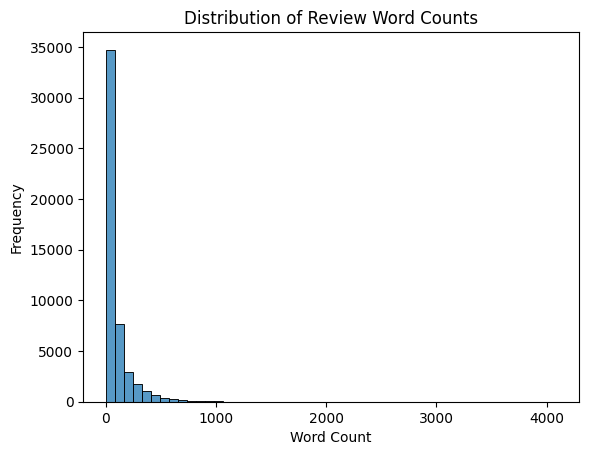

In [8]:
# Word Count Histogram
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Add word count column
sample_50k_df['word_count'] = sample_50k_df['reviewText'].apply(lambda x: len(str(x).split()))

# Plot histogram
sns.histplot(sample_50k_df['word_count'], bins=50)
plt.title("Distribution of Review Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


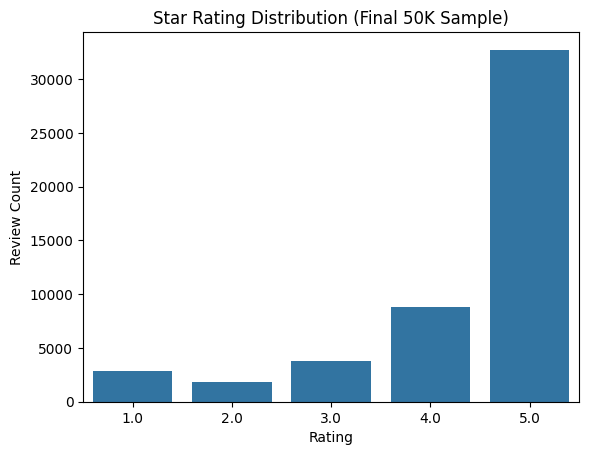

In [9]:
# Plot Star Rating Distribution

sns.countplot(data=sample_50k_df, x="overall")
plt.title("Star Rating Distribution (Final 50K Sample)")
plt.xlabel("Rating")
plt.ylabel("Review Count")
plt.show()


In [10]:
# Preprocessing Pipeline

import re
import string

# stopword set
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

# Drop duplicates
sample_50k_df.drop_duplicates(subset=["reviewText"], inplace=True)

# Clean review text
sample_50k_df["cleaned_text"] = sample_50k_df["reviewText"].apply(clean_text)

# Tokenize
sample_50k_df["tokens"] = sample_50k_df["cleaned_text"].apply(lambda x: x.split())


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# 3-class sentiment label based on the star rating (overall)

def map_sentiment(rating):
    if rating in [1.0, 2.0]:
        return "negative"
    elif rating == 3.0:
        return "neutral"
    else:
        return "positive"

# cleaned DataFrame
sample_50k_df['sentiment'] = sample_50k_df['overall'].apply(map_sentiment)

In [12]:
# Metrics for Preprocessing Summary
# Data Removed or Cleaned

print("Initial record count: 50,000")
print("After removing duplicates:", sample_50k_df.shape[0])
print("Average word count (after cleaning):", sample_50k_df['word_count'].mean())
print("Average number of tokens:", sample_50k_df['tokens'].apply(len).mean())


Initial record count: 50,000
After removing duplicates: 47795
Average word count (after cleaning): 90.6237263312062
Average number of tokens: 45.841782613244064


In [13]:
# Save preprocessed data
sample_50k_df.to_csv("amazon_reviews_cleaned_50k.csv", index=False)

 Saved the Cleaned Data set as CSV to local system


In [14]:
# Installing  Required Libraries
# !pip install transformers --quiet
# !pip install torch --quiet
# !pip install sentencepiece --quiet


In [15]:
# Load Model and Tokenizer
# ABSA BERT model (can extract aspects + polarity)

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_name = "yangheng/deberta-v3-base-absa-v1.1"

# Use slow tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Setup pipeline
aspect_extractor = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


2025-05-31 16:08:02.280619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 16:08:02.293589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748707682.309846   38904 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748707682.314714   38904 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748707682.327468   38904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [16]:
# Apply on 10 Sample Review Texts
sample_texts = sample_50k_df['cleaned_text'].sample(10, random_state=42).tolist()

for review in sample_texts:
    print(f"\n Review:\n{review}")
    print("\n Extracted Aspects:")
    output = aspect_extractor(review)
    for ent in output:
        print(f"- {ent['word']} (label: {ent['entity_group']})")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 Review:
awesome makes drinks quick hot

 Extracted Aspects:
- awesome (label: Positive)
- makes drinks (label: Neutral)
- quick (label: Positive)
- hot (label: Neutral)

 Review:
neat set im using together still great short cords great travel charger set port charger charger good longer cord either way im happy

 Extracted Aspects:
- neat set im using together still great (label: Positive)
- short (label: Neutral)
- cords great travel charger set port charger (label: Positive)
- charger (label: Negative)
- good longer cord either way im happy (label: Positive)

 Review:
love colors

 Extracted Aspects:
- love colors (label: Positive)

 Review:
small compact charger works fast heavier expected work well like baby blue color choice

 Extracted Aspects:
- small compact (label: Neutral)
- charger works fast (label: Positive)
- heavier (label: Neutral)
- expected work (label: Positive)
- well like (label: Neutral)
- baby blue color (label: Positive)
- choice (label: Neutral)

 Review:
lik

In [17]:
# Batch Aspect Extraction on 5K Reviews

# 50K sample
bert_batch_df = sample_50k_df.copy()

# Define safe aspect extractor
def extract_bert_aspects(text):
    try:
        return aspect_extractor(text)
    except Exception as e:
        print("Error on text:", text[:100])
        print("Error:", e)
        return []

bert_batch_df["bert_aspects"] = bert_batch_df["cleaned_text"].apply(extract_bert_aspects)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [18]:
 # Save locally in CSV after extraction
bert_batch_df.to_csv("amazon_reviews_50k_with_aspects.csv", index=False)

 Saved the  amazon reviews 50k records Data with aspects as CSV to local system


In [19]:
# Extracting aspect phrases + polarity from 50K batch

# Extract all aspect words and polarity from BERT output
aspect_records = []

for _, row in bert_batch_df.iterrows():
    for aspect in row['bert_aspects']:
        aspect_records.append({
            "review_id": row.name,
            "aspect": aspect['word'].strip(),
            "sentiment": aspect['entity_group']
        })

# Convert to DataFrame
import pandas as pd
aspect_df = pd.DataFrame(aspect_records)
aspect_df.head()

# Balance the aspect_df

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Encode labels first
aspect_df['label'] = aspect_df['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

# Separate by class
neg = aspect_df[aspect_df['label'] == 0]
neu = aspect_df[aspect_df['label'] == 1]
pos = aspect_df[aspect_df['label'] == 2]

# Downsample each to 16666 (total ≈ 5K)
min_samples = min(len(neg), len(neu), len(pos), 16666)
neg_down = resample(neg, replace=False, n_samples=min_samples, random_state=42)
neu_down = resample(neu, replace=False, n_samples=min_samples, random_state=42)
pos_down = resample(pos, replace=False, n_samples=min_samples, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([neg_down, neu_down, pos_down]).sample(frac=1, random_state=42).reset_index(drop=True)

# Replace aspect_df with balanced version
aspect_df = balanced_df.copy()


/tmp/ipykernel_38904/1969468926.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(aspect_df, x='review_id', y='sentiment', inner='box', palette='Dark2')


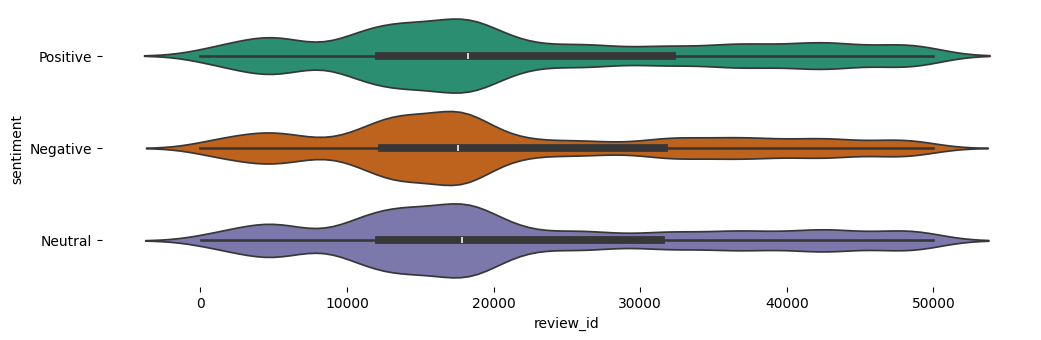

In [20]:
# sentiment vs review_id - Aspect ID

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(aspect_df['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aspect_df, x='review_id', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

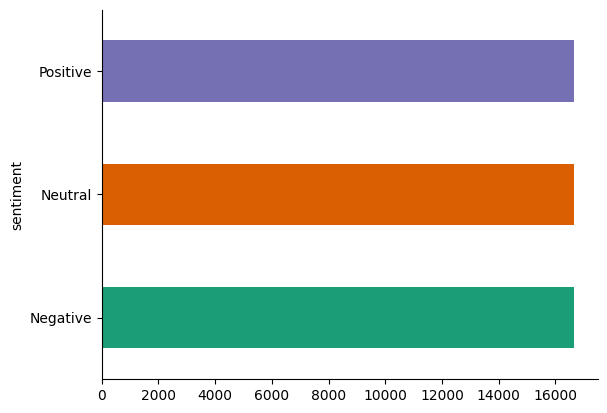

In [21]:
# sentiment

from matplotlib import pyplot as plt
import seaborn as sns
aspect_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [22]:
# Clean and filter - remove empty aspects
aspect_df = aspect_df[aspect_df["aspect"].str.len() > 1]


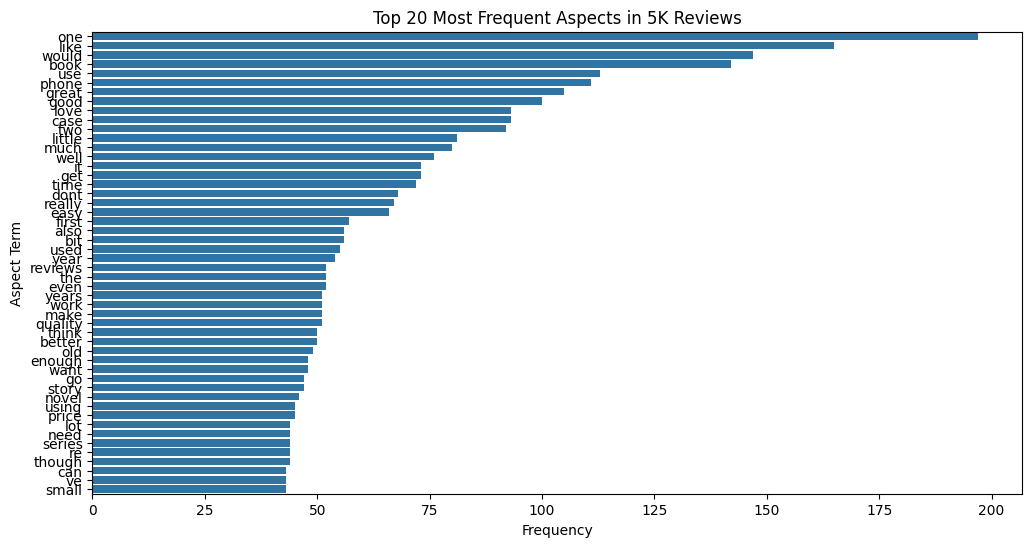

In [23]:
# Visualize Top 20 Aspects by Frequency

import seaborn as sns
import matplotlib.pyplot as plt

#top_aspects = aspect_df['aspect'].value_counts().nlargest(20)
top_aspects = aspect_df['aspect'].value_counts().nlargest(50)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_aspects.values, y=top_aspects.index)
plt.title("Top 20 Most Frequent Aspects in 5K Reviews")
plt.xlabel("Frequency")
plt.ylabel("Aspect Term")
plt.show()


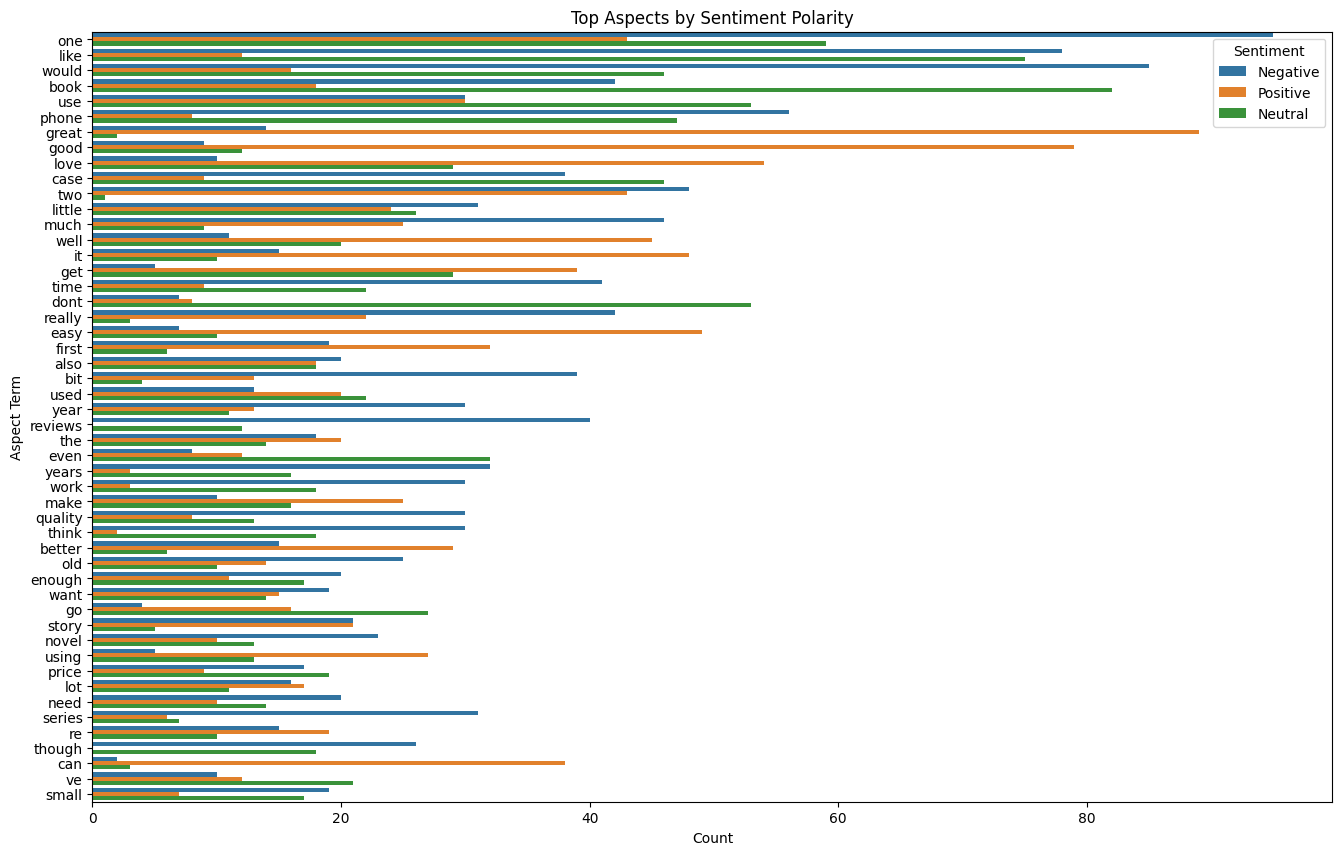

In [24]:
# Visualize Aspect Terms by Sentiment (Grouped)

# Plot top 50 aspect terms by sentiment label
top_aspects = aspect_df["aspect"].value_counts().nlargest(50).index
subset = aspect_df[aspect_df["aspect"].isin(top_aspects)]

plt.figure(figsize=(16, 10))
sns.countplot(data=subset, y="aspect", hue="sentiment", order=top_aspects)
plt.title("Top Aspects by Sentiment Polarity")
plt.xlabel("Count")
plt.ylabel("Aspect Term")
plt.legend(title="Sentiment")
plt.show()


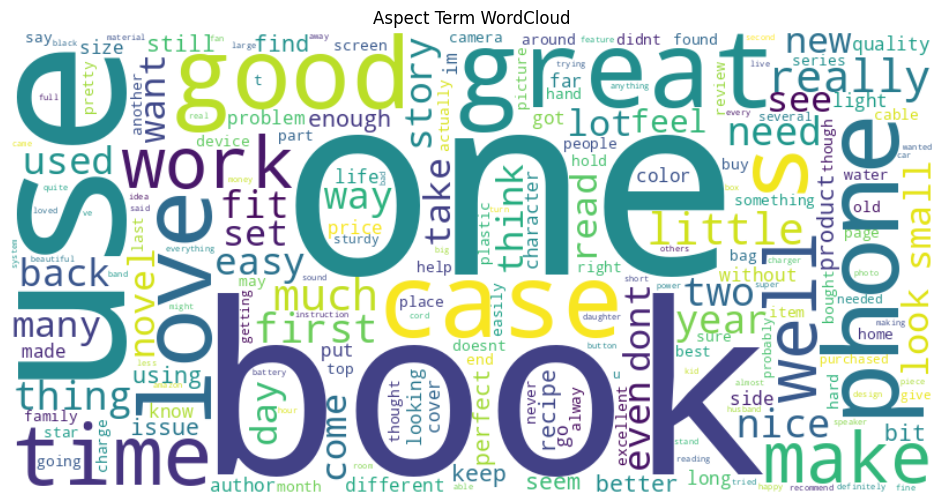

In [25]:
# Generating  Wordcloud of Aspects

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all aspect words
text = " ".join(aspect_df["aspect"])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Aspect Term WordCloud")
plt.show()


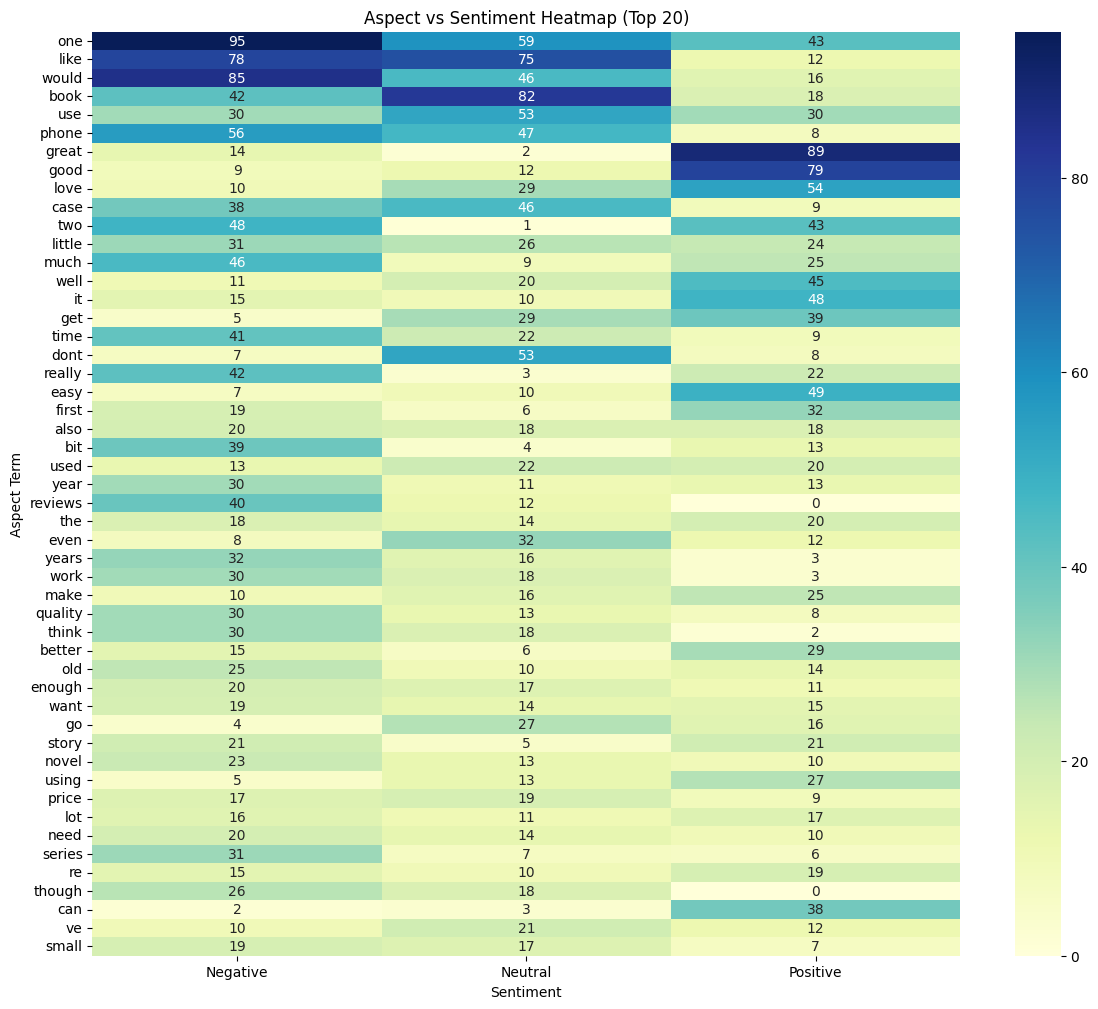

In [26]:
# Aspect vs Sentiment Heatmap

import seaborn as sns
import pandas as pd

# Create crosstab
heat_df = pd.crosstab(aspect_df["aspect"], aspect_df["sentiment"])

# top 50 aspects
heat_df = heat_df.loc[aspect_df["aspect"].value_counts().nlargest(50).index]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(heat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Aspect vs Sentiment Heatmap (Top 20)")
plt.xlabel("Sentiment")
plt.ylabel("Aspect Term")
plt.show()


In [27]:
# Setup - Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [28]:
# balanced 50K dataset (aspect_df)
X = aspect_df["aspect"]
y = aspect_df["label"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



🔹 Logistic Regression
              precision    recall  f1-score   support

           0       0.49      0.62      0.54      3236
           1       0.53      0.49      0.51      3247
           2       0.59      0.47      0.52      3270

    accuracy                           0.53      9753
   macro avg       0.53      0.53      0.53      9753
weighted avg       0.53      0.53      0.53      9753



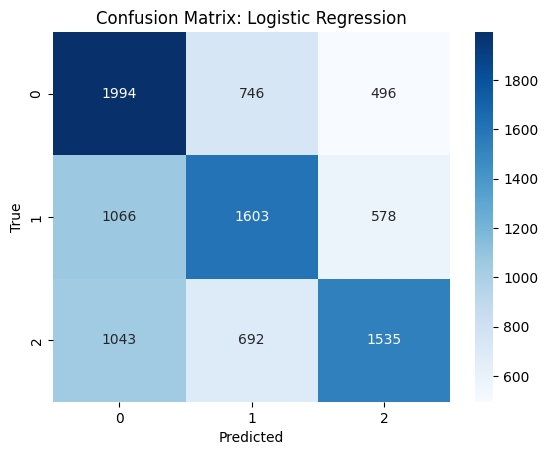

In [29]:
# Train Models

# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)


sentiment_metrics = {}

sentiment_metrics["Logistic Regression"] = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, average='weighted'),
    "F1": f1_score(y_test, y_pred_lr, average='weighted')
}

print(" Logistic Regression")
print(classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



🔹 Support Vector Machine
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      3236
           1       0.52      0.49      0.51      3247
           2       0.59      0.47      0.52      3270

    accuracy                           0.53      9753
   macro avg       0.53      0.53      0.52      9753
weighted avg       0.53      0.53      0.52      9753



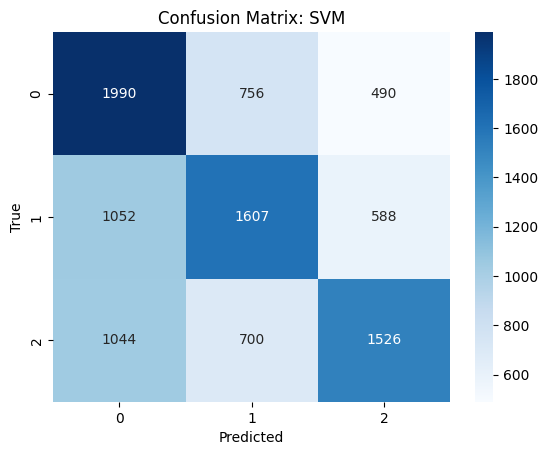

In [30]:
# Support Vector Machine (LinearSVC)
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

sentiment_metrics["SVM"] = {
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
    "F1": f1_score(y_test, y_pred_svm, average='weighted')
}

print(" Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


🔹 Naive Bayes
              precision    recall  f1-score   support

           0       0.54      0.44      0.49      3236
           1       0.52      0.49      0.51      3247
           2       0.51      0.62      0.56      3270

    accuracy                           0.52      9753
   macro avg       0.52      0.52      0.52      9753
weighted avg       0.52      0.52      0.52      9753



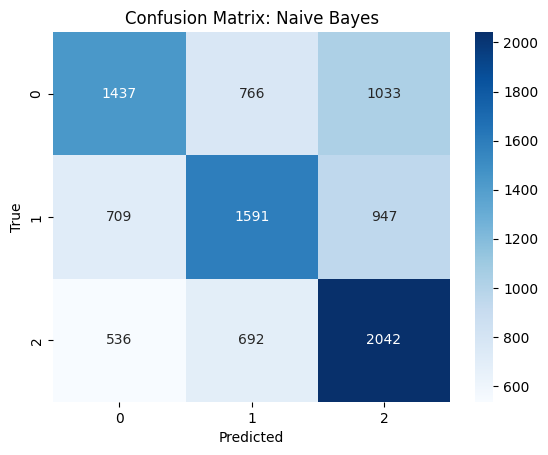

In [31]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

sentiment_metrics["Naive Bayes"] = {
    "Model": "Naive Bayes",
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_nb, average='weighted'),
    "F1": f1_score(y_test, y_pred_nb, average='weighted')
}

print(" Naive Bayes")
print(classification_report(y_test, y_pred_nb))

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [32]:
# DistilBERT Sentiment Classification

# Setup

# !pip install transformers -q
# !pip install tf-keras -q
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch



In [33]:
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Prepare train-test split
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
aspect_df["label"] = aspect_df["sentiment"].map(label_map)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    aspect_df["aspect"].tolist(),
    aspect_df["label"].tolist(),
    test_size=0.2,
    stratify=aspect_df["label"],
    random_state=42
)

In [34]:
# Tokenization
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)




In [35]:
#  Create HuggingFace Dataset
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': test_labels
})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [36]:
# Load DistilBERT Model
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# !pip install accelerate -q

In [38]:
# Train the Model
# disable wandb logging
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments, Trainer

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1
)

# Setup trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
)

# Train
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,1.109700
20,1.099200
30,1.091100
40,1.103300
50,1.069100
60,1.092700
70,1.028700
80,1.048100
90,1.029800
100,1.074000


TrainOutput(global_step=7314, training_loss=0.7333622586704324, metrics={'train_runtime': 360.4602, 'train_samples_per_second': 324.652, 'train_steps_per_second': 20.291, 'total_flos': 3330538172945280.0, 'train_loss': 0.7333622586704324, 'epoch': 3.0})

🔹 DistilBERT
              precision    recall  f1-score   support

    Negative       0.57      0.65      0.61      3236
     Neutral       0.62      0.54      0.58      3247
    Positive       0.63      0.62      0.62      3270

    accuracy                           0.60      9753
   macro avg       0.61      0.60      0.60      9753
weighted avg       0.61      0.60      0.60      9753



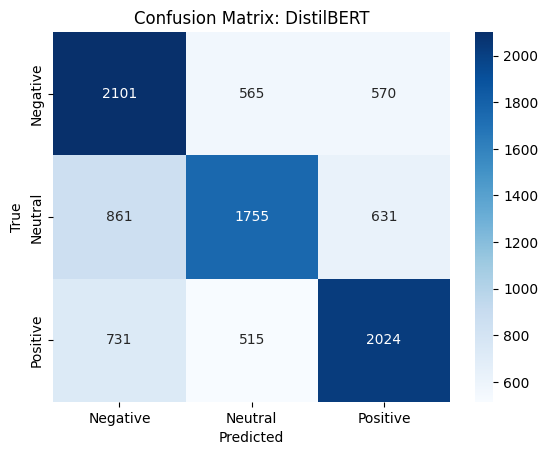

In [39]:
# Evaluate & Compare

# Get predictions
preds = trainer.predict(dataset["test"])
y_true = np.array(test_labels)
y_pred = np.argmax(preds.predictions, axis=1)

# Store DistilBERT scores dynamically
sentiment_metrics["DistilBERT"] = {
    "Model": "DistilBERT",
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
    "Recall": recall_score(y_true, y_pred, average='weighted'),
    "F1": f1_score(y_true, y_pred, average='weighted')
}

print(" DistilBERT")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("Confusion Matrix: DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [40]:
# Save Sentiment Model Metrics to CSV
sentiment_metrics_df = pd.DataFrame(sentiment_metrics).T
sentiment_metrics_df.to_csv("sentiment_evaluation_results.csv")
sentiment_metrics_df

,Model,Accuracy,Precision,Recall,F1
Logistic Regression,Logistic Regression,0.526197,0.534004,0.526197,0.525124
SVM,SVM,0.525274,0.532744,0.525274,0.524132
Naive Bayes,Naive Bayes,0.51984,0.521722,0.51984,0.517171
DistilBERT,DistilBERT,0.602891,0.60528,0.602891,0.602311


In [41]:
# Sarcasm Detection Code
from transformers import pipeline
import pandas as pd

# Initialize storage list for sarcasm model scores
sarcasm_metrics = {}


In [42]:
# Load Reviews -  50K for sarcasm detection
review_texts = sample_50k_df["reviewText"].dropna().astype(str).tolist()


In [43]:
from transformers import pipeline

# Load Pretrained Sarcasm Classifier
# Roberta-based sarcasm detection

sarcasm_model = pipeline(
    "text-classification",
    model="helinivan/english-sarcasm-detector"
)

Device set to use cuda:0


In [44]:
# # Load Pretrained Sarcasm Classifier
# sarcasm_model = pipeline("text-classification",
#                          model="mrm8488/t5-base-finetuned-sarcasm-twitter",
#                          tokenizer="mrm8488/t5-base-finetuned-sarcasm-twitter")

In [45]:
# Run Predictions

# Sarcasm inference on full dataset
sarcasm_preds = sarcasm_model(review_texts, truncation=True)

# Save back into main DataFrame
sample_50k_df = sample_50k_df.copy()
sample_50k_df["sarcasm_label"] = [pred["label"] for pred in sarcasm_preds]

# Define subset alias
bert_batch_df_subset = sample_50k_df

In [46]:
# Inspect Output

bert_batch_df_subset[["reviewText", "sarcasm_label"]].head(10)


,reviewText,sarcasm_label
0,First & most offensive: they reek of gasoline ...,LABEL_0
1,These didn’t work. Idk if they were damaged in...,LABEL_0
2,I love these. They even come with a carry case...,LABEL_0
3,I was searching for a sturdy backpack for scho...,LABEL_0
4,I've bought these headphones three times becau...,LABEL_0
5,"Light weight, quiet and totally awesome!!! It ...",LABEL_0
6,Update 2-they sent a new warranty replacement....,LABEL_0
7,These are fantastic headphones and I love that...,LABEL_0
8,pretty good for the price.,LABEL_0
9,yes.. so good. just buy it. my favorite featu...,LABEL_0


In [47]:
# Map Sarcasm Back to Aspect-Level Data

# Join on review_id 
aspect_df = aspect_df.merge(bert_batch_df_subset[["sarcasm_label"]],
                            left_on="review_id",
                            right_index=True,
                            how="left")


/tmp/ipykernel_38904/4078972753.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sarcasm_counts.index, y=sarcasm_counts.values, palette="Set2")


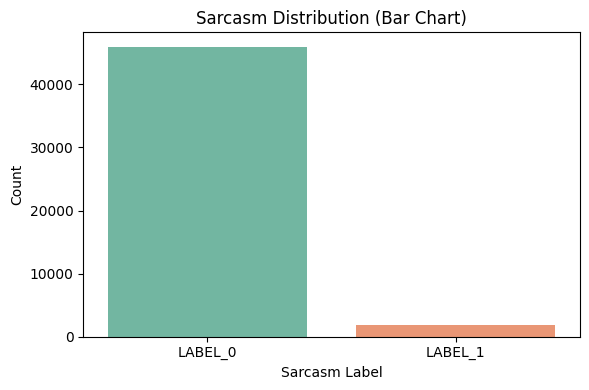

In [48]:
# Bar Chart of Sarcasm Labels

import matplotlib.pyplot as plt
import seaborn as sns

# Count sarcasm labels
sarcasm_counts = bert_batch_df_subset["sarcasm_label"].value_counts()

# Bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=sarcasm_counts.index, y=sarcasm_counts.values, palette="Set2")
plt.title("Sarcasm Distribution (Bar Chart)")
plt.xlabel("Sarcasm Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


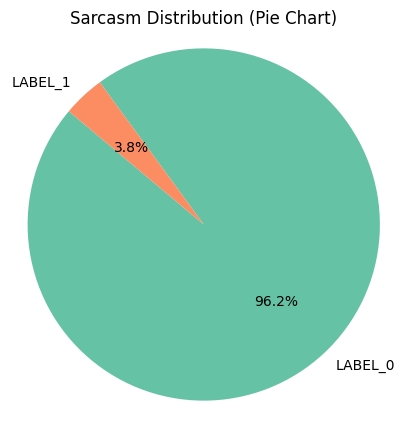

In [49]:
# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(sarcasm_counts, labels=sarcasm_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Sarcasm Distribution (Pie Chart)")
plt.axis("equal")
plt.show()


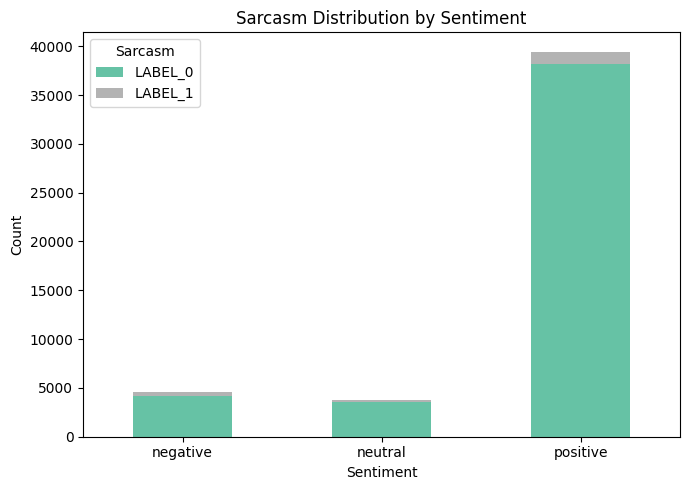

In [50]:
#Sarcasm vs Sentiment Overlap (Stacked Bar Chart)
# Cross-tabulation of sarcasm vs sentiment
sarcasm_sentiment_ct = pd.crosstab(bert_batch_df_subset["sentiment"], bert_batch_df_subset["sarcasm_label"])

# Plot
sarcasm_sentiment_ct.plot(kind="bar", stacked=True, figsize=(7, 5), colormap="Set2")
plt.title("Sarcasm Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title="Sarcasm")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


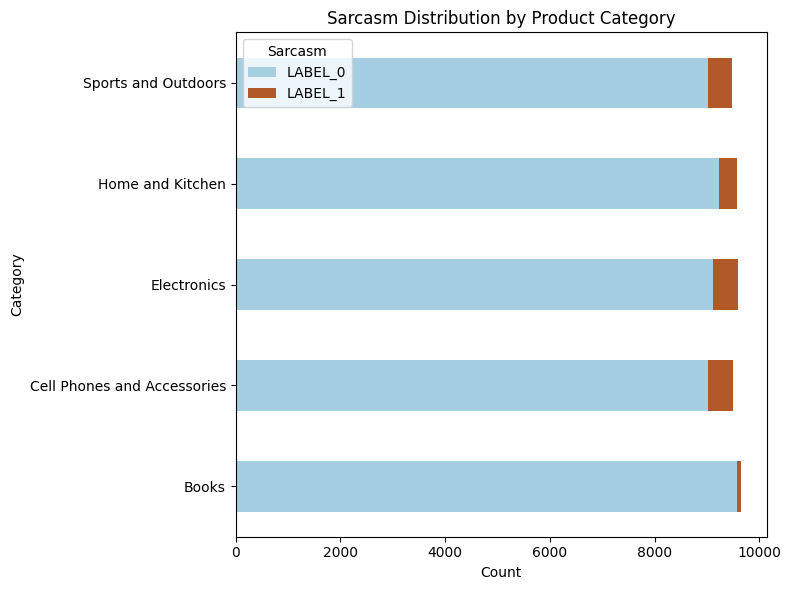

In [51]:
# Sarcasm vs product Category ( Horizontal Bar Chart)

sarcasm_category_ct = pd.crosstab(bert_batch_df_subset["category"], bert_batch_df_subset["sarcasm_label"])

# Plot
sarcasm_category_ct.plot(kind="barh", stacked=True, figsize=(8, 6), colormap="Paired")
plt.title("Sarcasm Distribution by Product Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.legend(title="Sarcasm")
plt.tight_layout()
plt.show()


In [52]:
# pip install -U "jinja2>=3.1.2" -q

sarcasm_label,LABEL_0,LABEL_1
sentiment,,
negative,91.58%,8.42%
neutral,95.18%,4.82%
positive,96.79%,3.21%


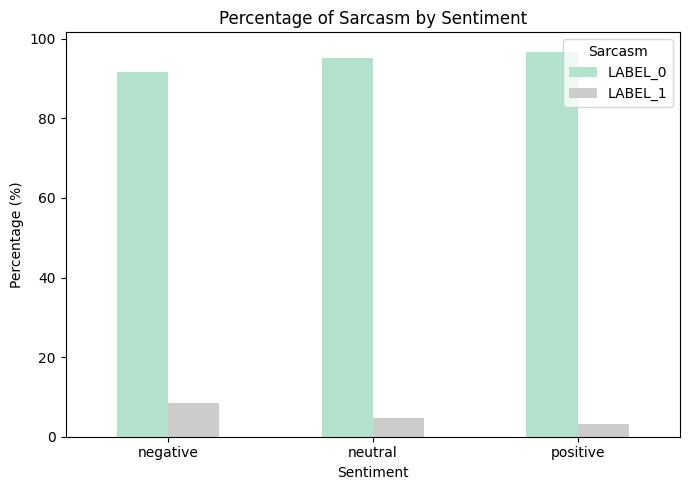

In [53]:
#  Sarcasm Ratio by Sentiment (Table & Bar Plot)

# Count total and sarcastic entries per sentiment
sarcasm_sentiment_pct = bert_batch_df_subset.groupby("sentiment")["sarcasm_label"].value_counts(normalize=True).unstack().fillna(0) * 100

# Display as table
display(sarcasm_sentiment_pct.style.format("{:.2f}%").set_caption("Sarcasm Ratio (%) by Sentiment"))

# Plot
sarcasm_sentiment_pct.plot(kind="bar", figsize=(7, 5), colormap="Pastel2")
plt.title("Percentage of Sarcasm by Sentiment")
plt.ylabel("Percentage (%)")
plt.xlabel("Sentiment")
plt.legend(title="Sarcasm")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


sarcasm_label,LABEL_0,LABEL_1
category,,
Books,99.21%,0.79%
Cell Phones and Accessories,94.96%,5.04%
Electronics,95.10%,4.90%
Home and Kitchen,96.32%,3.68%
Sports and Outdoors,95.16%,4.84%


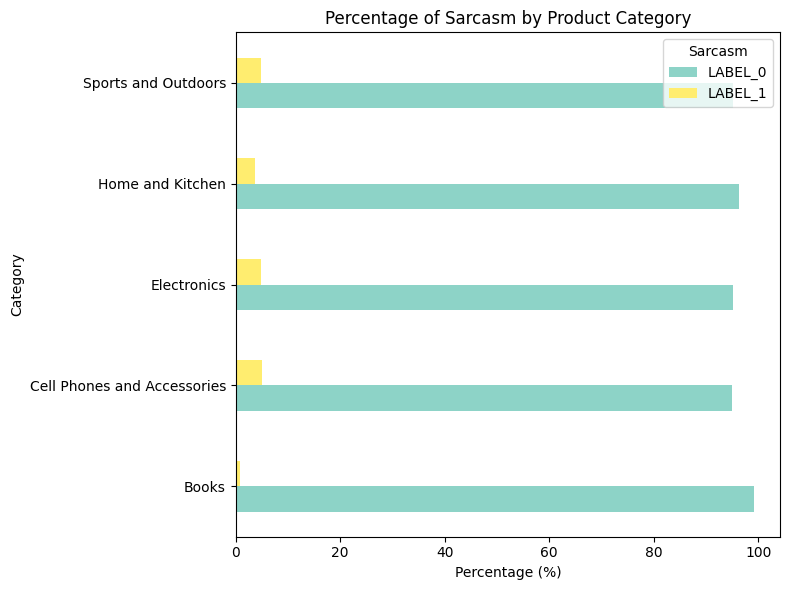

In [54]:
# Sarcasm Ratio by Category (Table & Bar Plot)

# Count total and sarcastic entries per category
sarcasm_category_pct = bert_batch_df_subset.groupby("category")["sarcasm_label"].value_counts(normalize=True).unstack().fillna(0) * 100

# Display as table
display(sarcasm_category_pct.style.format("{:.2f}%").set_caption("Sarcasm Ratio (%) by Category"))

# Plot
sarcasm_category_pct.plot(kind="barh", figsize=(8, 6), colormap="Set3")
plt.title("Percentage of Sarcasm by Product Category")
plt.xlabel("Percentage (%)")
plt.ylabel("Category")
plt.legend(title="Sarcasm")
plt.tight_layout()
plt.show()


In [55]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Prepare data
X = bert_batch_df_subset["reviewText"].astype(str)
y = bert_batch_df_subset["sarcasm_label"].map({"SARCASTIC": 1, "NOT_SARCASTIC": 0})

# Drop rows with missing labels
valid_idx = y.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]


from sklearn.utils import resample
import pandas as pd

# Combine data
df = bert_batch_df_subset[["reviewText", "sarcasm_label"]].dropna()

# Separate classes
df_majority = df[df["sarcasm_label"] == "LABEL_0"]
df_minority = df[df["sarcasm_label"] == "LABEL_1"]

# Upsample minority
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Continue with X, y
X = df_balanced["reviewText"].astype(str)
y = df_balanced["sarcasm_label"].map({"LABEL_1": 1, "LABEL_0": 0})


X_train, X_test, y_train, y_test = train_test_split(
    X, y,stratify=y, test_size=0.2, random_state=42  # removed stratify=y
)


# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



In [56]:
# Check label distribution
bert_batch_df_subset["sarcasm_label"].value_counts(dropna=False)


sarcasm_label
LABEL_0    45959
LABEL_1     1836
Name: count, dtype: int64

🔹 Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9192
           1       0.90      0.99      0.94      9192

    accuracy                           0.94     18384
   macro avg       0.95      0.94      0.94     18384
weighted avg       0.95      0.94      0.94     18384



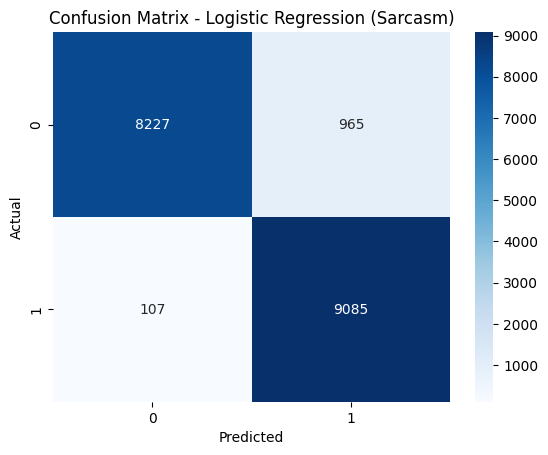

In [57]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Initialize model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# # Evaluate

sarcasm_metrics["Logistic Regression (Sarcasm)"] = {
    "Model": "Logistic Regression (Sarcasm)",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, average='weighted'),
    "F1": f1_score(y_test, y_pred_lr, average='weighted')
}

# Report
print(" Logistic Regression")
print(classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Sarcasm)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



🔹 Support Vector Machine
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9192
           1       0.93      1.00      0.96      9192

    accuracy                           0.96     18384
   macro avg       0.96      0.96      0.96     18384
weighted avg       0.96      0.96      0.96     18384



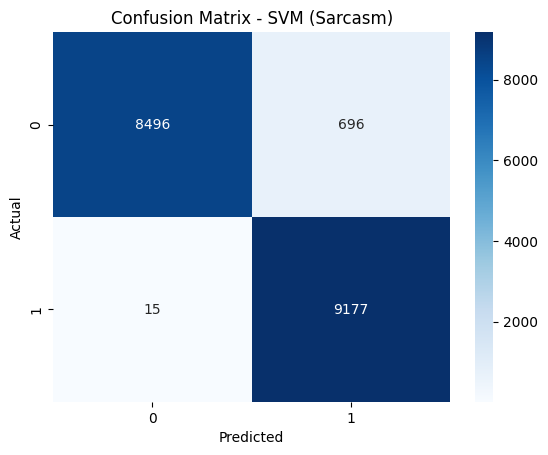

In [58]:
# SVM
from sklearn.svm import LinearSVC

# Train
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate
sarcasm_metrics["SVM (Sarcasm)"] = {
    "Model": "SVM (Sarcasm)",
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
    "F1": f1_score(y_test, y_pred_svm, average='weighted')
}

# Report
print(" Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM (Sarcasm)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



🔹 Naive Bayes
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      9192
           1       0.87      0.91      0.89      9192

    accuracy                           0.89     18384
   macro avg       0.89      0.89      0.89     18384
weighted avg       0.89      0.89      0.89     18384



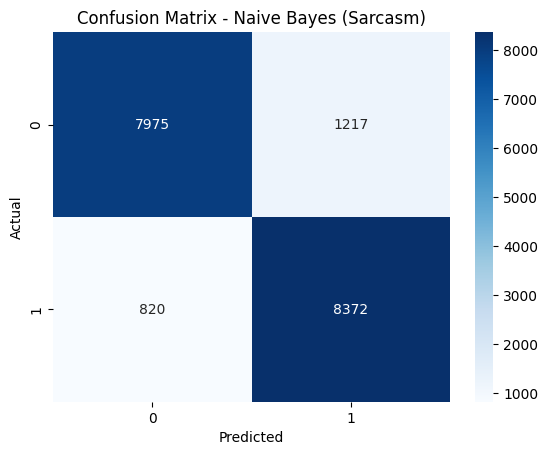

In [59]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Train
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Evaluate

sarcasm_metrics["Naive Bayes (Sarcasm)"] = {
    "Model": "Naive Bayes (Sarcasm)",
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_nb, average='weighted'),
    "F1": f1_score(y_test, y_pred_nb, average='weighted')
}

# Report
print(" Naive Bayes")
print(classification_report(y_test, y_pred_nb))

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (Sarcasm)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [60]:
# Save sarcasm Model Metrics to CSV
sarcasm_metrics_df = pd.DataFrame(sarcasm_metrics).T
sarcasm_metrics_df.to_csv("sarcasm_model_evaluation_results.csv")
sarcasm_metrics_df

,Model,Accuracy,Precision,Recall,F1
Logistic Regression (Sarcasm),Logistic Regression (Sarcasm),0.941688,0.945571,0.941688,0.941561
SVM (Sarcasm),SVM (Sarcasm),0.961325,0.963871,0.961325,0.961272
Naive Bayes (Sarcasm),Naive Bayes (Sarcasm),0.889197,0.889924,0.889197,0.889145


In [61]:
print(aspect_df.columns.tolist())


['review_id', 'aspect', 'sentiment', 'label', 'sarcasm_label']


In [65]:
# aspect_df["sarcasm_label"] = aspect_df["sarcasm_label_y"]

# Grouped summary table
summary_table = aspect_df.groupby(["sentiment", "sarcasm_label"])["aspect"].count().unstack(fill_value=0)

# Optional: Rename columns for better clarity
summary_table.columns = ['Not Sarcastic', 'Sarcastic']
summary_table = summary_table.reset_index()

# Display the summary
display(summary_table)


,sentiment,Not Sarcastic,Sarcastic
0,Negative,16091,89
1,Neutral,16148,83
2,Positive,16218,132


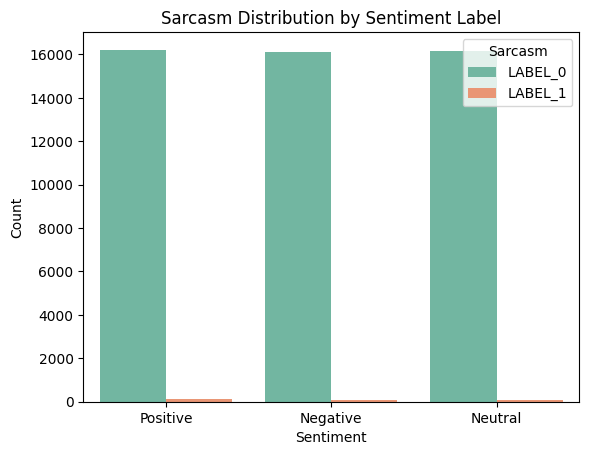

In [66]:
# Visualize Sarcasm Distribution by Sentiment
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=aspect_df, x="sentiment", hue="sarcasm_label", palette="Set2")
plt.title("Sarcasm Distribution by Sentiment Label")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title="Sarcasm")
plt.show()


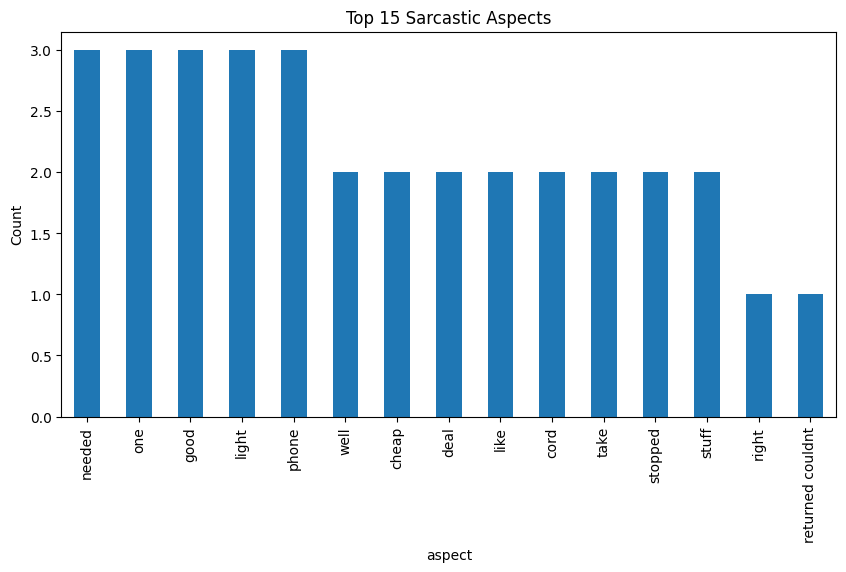

In [67]:
# Find most sarcastic aspects

top_sarcastic_aspects = (
    aspect_df[aspect_df["sarcasm_label"] == "LABEL_1"]
    .groupby("aspect")
    .size()
    .sort_values(ascending=False)
    .head(15)
)

top_sarcastic_aspects.plot(kind="bar", title="Top 15 Sarcastic Aspects", figsize=(10,5))
plt.ylabel("Count")
plt.show()


In [68]:
# Summary Table: Sentiment vs Sarcasm Count
summary_table = (
    aspect_df
    .groupby(["sentiment", "sarcasm_label"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={"LABEL_0": "Not Sarcastic", "LABEL_1": "Sarcastic"})
)

print("Summary of Sentiment vs Sarcasm:")
display(summary_table)


Summary of Sentiment vs Sarcasm:


sarcasm_label,Not Sarcastic,Sarcastic
sentiment,,
Negative,16091,89
Neutral,16148,83
Positive,16218,132


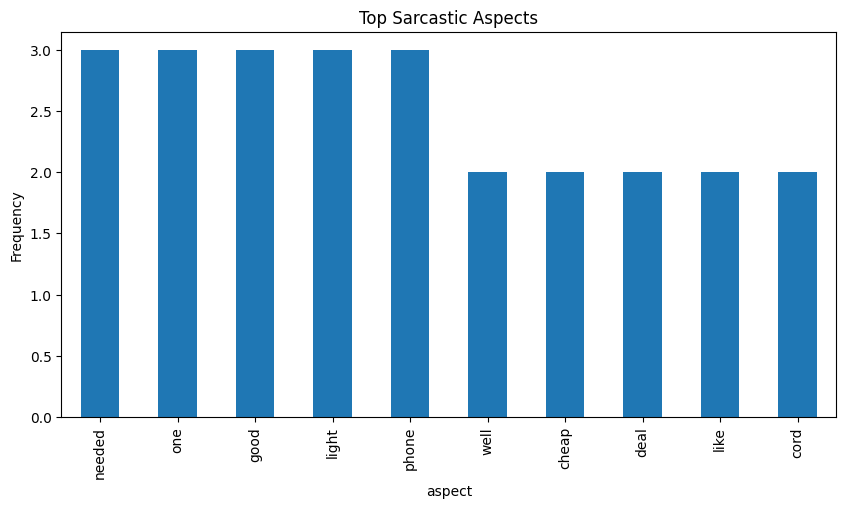

In [69]:
# Most common sarcastic aspects
top_aspects = (
    aspect_df[aspect_df["sarcasm_label"] == "LABEL_1"]
    .groupby("aspect")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

top_aspects.plot(kind="bar", title="Top Sarcastic Aspects", figsize=(10,5))
plt.ylabel("Frequency")
plt.show()


In [70]:
# Display Evaluation Summary for Sarcasm Models

# Save Sarcasm Model Metrics to CSV
sarcasm_results_df = pd.DataFrame(sarcasm_metrics).T
# Save Sarcasm Evaluation Metrics
sarcasm_results_df.to_csv("sarcasm_model_evaluation_results.csv")

sarcasm_results_df


,Model,Accuracy,Precision,Recall,F1
Logistic Regression (Sarcasm),Logistic Regression (Sarcasm),0.941688,0.945571,0.941688,0.941561
SVM (Sarcasm),SVM (Sarcasm),0.961325,0.963871,0.961325,0.961272
Naive Bayes (Sarcasm),Naive Bayes (Sarcasm),0.889197,0.889924,0.889197,0.889145


In [75]:
import os
assert os.path.exists("Final_3/sentiment_evaluation_results.csv"), "Sentiment metrics file missing!"
assert os.path.exists("Final_3/sarcasm_model_evaluation_results.csv"), "Sarcasm metrics file missing!"

/tmp/ipykernel_38904/799689056.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model", ci=None)


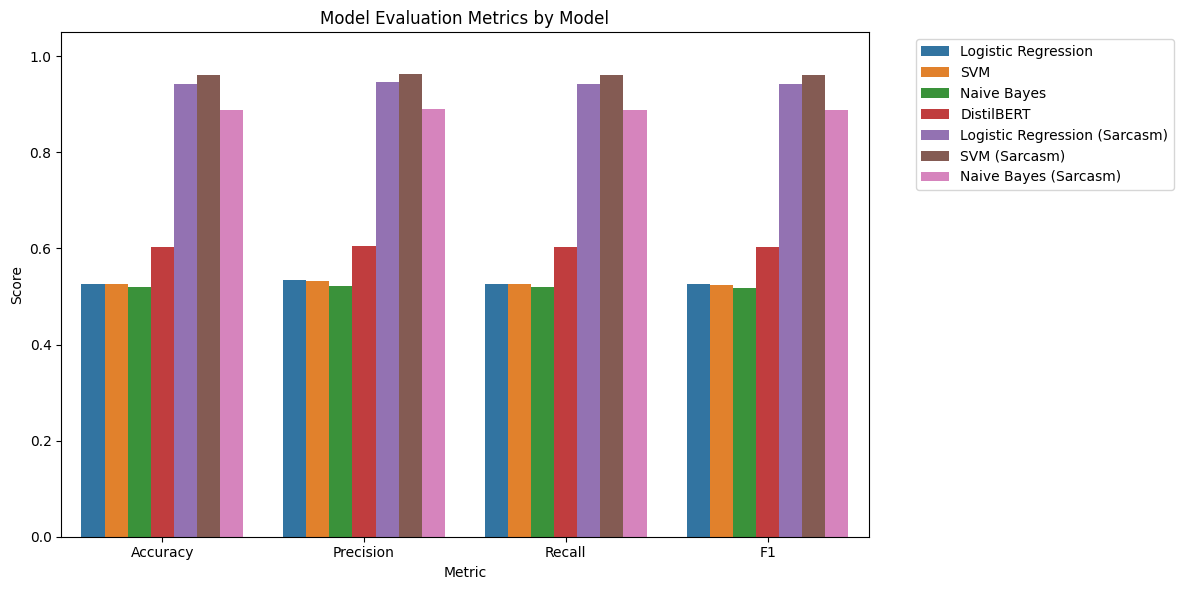

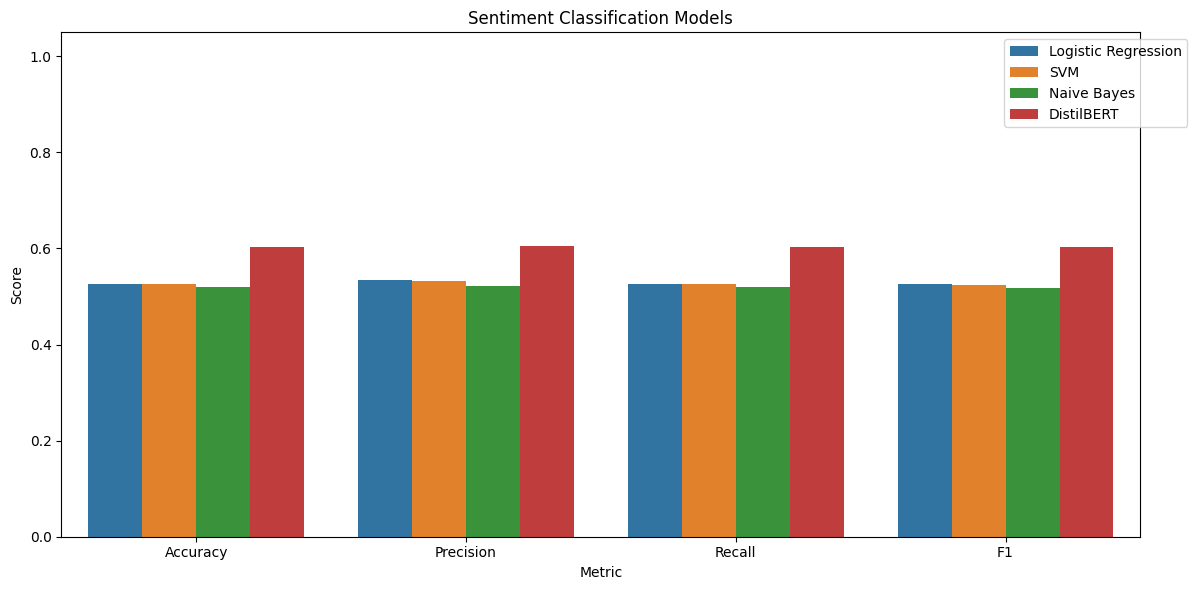

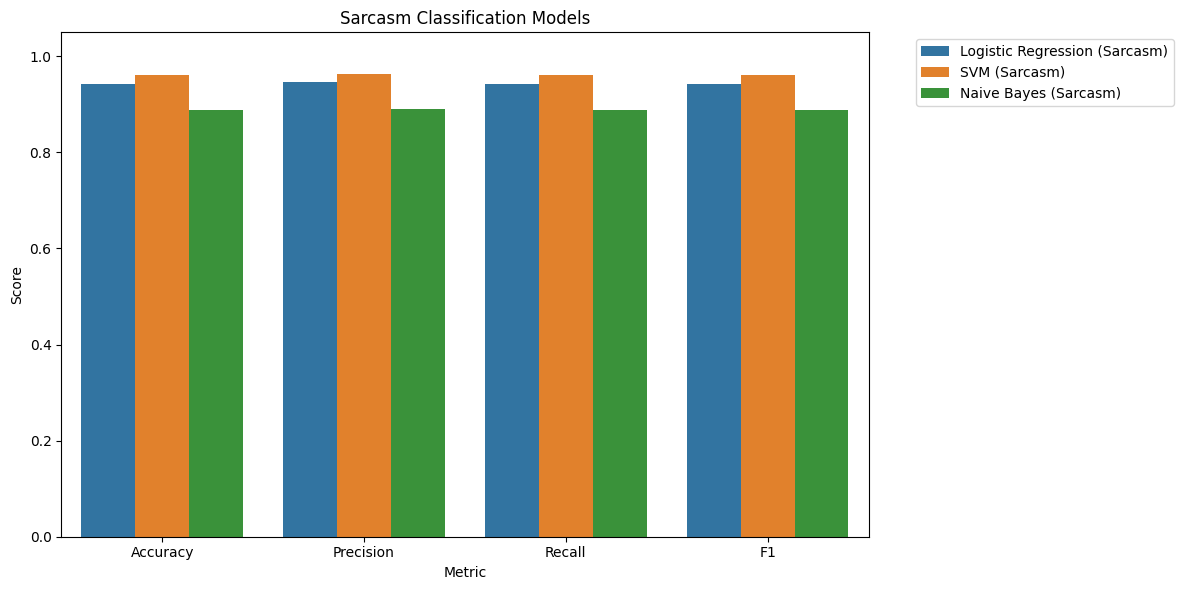

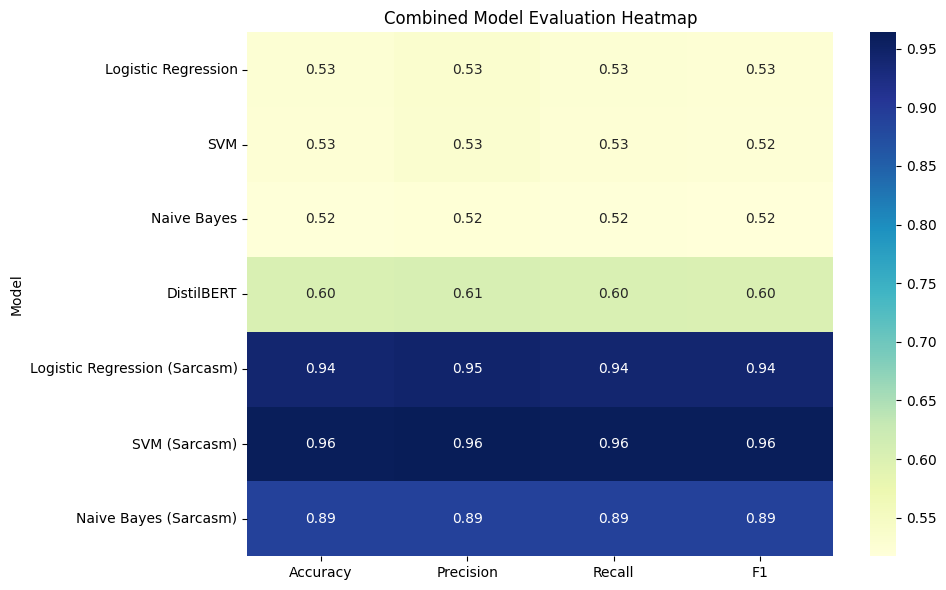

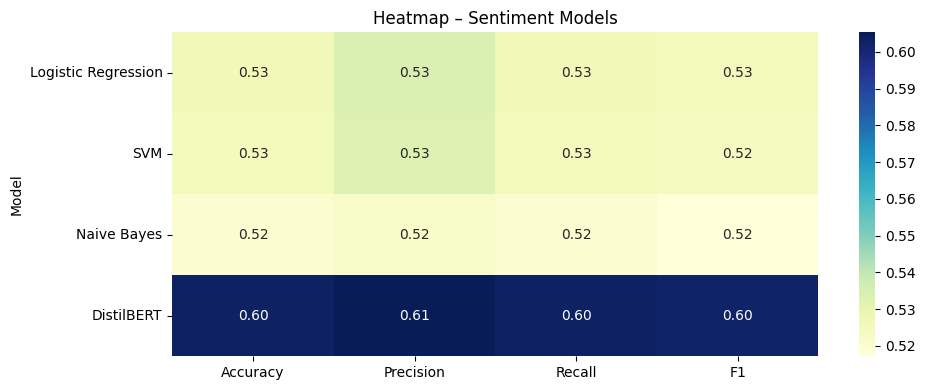

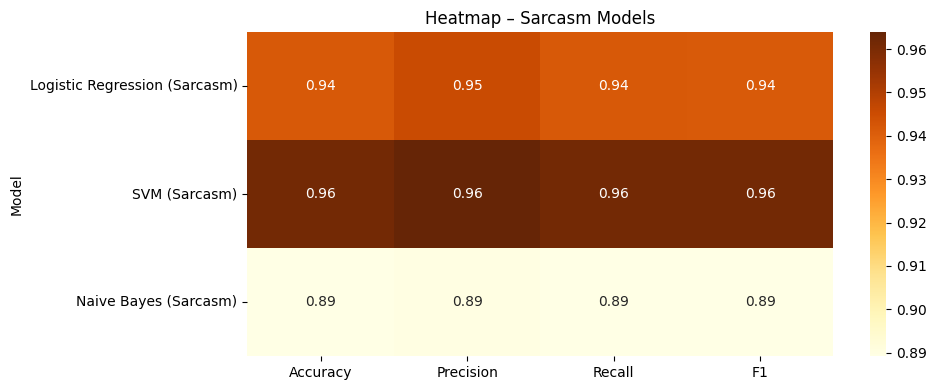

,Unnamed: 0,Model,Accuracy,Precision,Recall,F1,Task
0,Logistic Regression,Logistic Regression,0.526197,0.534004,0.526197,0.525124,Sentiment
1,SVM,SVM,0.525274,0.532744,0.525274,0.524132,Sentiment
2,Naive Bayes,Naive Bayes,0.519840,0.521722,0.519840,0.517171,Sentiment
3,DistilBERT,DistilBERT,0.602891,0.605280,0.602891,0.602311,Sentiment
4,Logistic Regression (Sarcasm),Logistic Regression (Sarcasm),0.941688,0.945571,0.941688,0.941561,Sarcasm
5,SVM (Sarcasm),SVM (Sarcasm),0.961325,0.963871,0.961325,0.961272,Sarcasm
6,Naive Bayes (Sarcasm),Naive Bayes (Sarcasm),0.889197,0.889924,0.889197,0.889145,Sarcasm


In [74]:
# Model Comparison & Evaluation + Visualization

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load stored evaluation results
sentiment_df = pd.read_csv("Final_3/sentiment_evaluation_results.csv")
sarcasm_df = pd.read_csv("Final_3/sarcasm_model_evaluation_results.csv")

# Add Task labels
sentiment_df["Task"] = "Sentiment"
sarcasm_df["Task"] = "Sarcasm"

# Combine both evaluations
combined_df = pd.concat([sentiment_df, sarcasm_df], ignore_index=True)

# Melt for long-format plotting
melted_df = combined_df.melt(
    id_vars=["Model", "Task"],
    value_vars=["Accuracy", "Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

# Bar Plot: All Models
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model", ci=None)
plt.title("Model Evaluation Metrics by Model")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Bar Plot: Sentiment Models
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df[melted_df["Task"] == "Sentiment"], x="Metric", y="Score", hue="Model")
plt.title("Sentiment Classification Models")
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Bar Plot: Sarcasm Models
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df[melted_df["Task"] == "Sarcasm"], x="Metric", y="Score", hue="Model")
plt.title("Sarcasm Classification Models")
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Combined Heatmap
heatmap_df = combined_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]]
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Combined Model Evaluation Heatmap")
plt.tight_layout()
plt.show()

# Split Heatmap: Sentiment
plt.figure(figsize=(10, 4))
sns.heatmap(
    sentiment_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]],
    annot=True, cmap="YlGnBu", fmt=".2f"
)
plt.title("Heatmap – Sentiment Models")
plt.tight_layout()
plt.show()

# Split Heatmap: Sarcasm
plt.figure(figsize=(10, 4))
sns.heatmap(
    sarcasm_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]],
    annot=True, cmap="YlOrBr", fmt=".2f"
)
plt.title("Heatmap – Sarcasm Models")
plt.tight_layout()
plt.show()

# Final Summary Table
display(combined_df.style.set_caption("Model Evaluation Summary"))
